In [1]:
%cd ..
%cd ..
%cd ..

/workspace/FLOOD_group2/models/CNN_model
/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


To run the cells in this notebook, the following .py files containing the functions and classes used in this assignment need to be imported.

In [2]:
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Preprocessing_Functions import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Class_Model import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Training_Functions import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Prediction_Functions import *
import random
from torchvision import transforms

<div align="center">

# INTRODUCTION

</div>

As observed in the previous Jupyter Notebook, the autoregressive model does not generalize well to test samples when the dike breach location changes. Therefore, this Jupyter Notebook introduces data augmentation technique, specifically flip in horizontal and vertical direction, on the training and validation datasets for the same model.

<div align="center">

# METHODOLOGY

</div>

The methodology employed in this Jupyter Notebook mirrors that of the previous one, with the exception that here we flip some samples of the training and validation datasets. This approach trains the model on various dike breach locations, enhancing its generalizability. This augmentation is achieved through the introduction of a custom class, CustomTrainingDataset, which implements both horizontal and vertical random flips on the training and validation datasets. For any given sample, there's a 50% chance (random.random() > 0.5) that it will undergo a horizontal flip, and independently, another 50% chance that it will undergo a vertical flip.





In [3]:
class CustomTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.hflip = transforms.RandomHorizontalFlip(p=1)
        self.vflip = transforms.RandomVerticalFlip(p=1)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the actual sample from the Subset
        sample = self.dataset[idx]

        inputs, targets = sample

        DEM = inputs[0]
        F1 = inputs[1]
        F2 = inputs[2]
        WD = inputs[3]
        T1 = targets[0]
        T2 = targets[1]
    
        # Apply the same random flip to both inputs and targets
        if random.random() > 0.5:
            DEM = torch.flip(DEM, [0])
            F1 = torch.flip(F1, [0])
            F2 = torch.flip(F2, [0])
            WD = torch.flip(WD, [0])
            T1 = torch.flip(T1, [0])
            T2 = torch.flip(T2, [0])

        # Apply the same random flip to both inputs and targets
        if random.random() > 0.5:
            DEM = torch.flip(DEM, [1])
            F1 = torch.flip(F1, [1])
            F2 = torch.flip(F2, [1])
            WD = torch.flip(WD, [1])
            T1 = torch.flip(T1, [1])
            T2 = torch.flip(T2, [1])

        inputs = torch.cat((DEM.unsqueeze(0), F1.unsqueeze(0), F2.unsqueeze(0), WD.unsqueeze(0)), dim=0)
        targets = torch.cat((T1.unsqueeze(0), T2.unsqueeze(0)), dim=0)
            
        return inputs, targets

<div align="center">

## Creation of the Training and Validation Datasets

</div>

### 1) Prepare the dataset to be splitted into training and validation datasets

In [4]:
complete_dataset_list = []


for file_id in range(1, 81):  # Loops through all the DEM file IDs that are numbered from 1 to 80 (training and validation files)
    elevation_slope_tensor = process_elevation_data_for_training(file_id).double()  # Shape: [3, 64, 64]
    
    # Initialize a list to store water depth tensors for all time steps
    target_tensors = []

    # Loop through all 96 time steps to collect water depth data using a step of 2
    for n in range(0, 96, 4):
        water_depth_tensor = process_water_depth_for_training(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor
    targets_tensor = torch.stack(target_tensors)

    # Create a dictionary for each sample to seperate inputs from targets
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    complete_dataset_list.append(sample)

### 2) Split dataset into train and validation

In [5]:
train_percnt = 0.8
train_size = int(train_percnt * len(complete_dataset_list))
val_size = len(complete_dataset_list) - train_size
train_dataset, val_dataset = random_split(complete_dataset_list, [train_size, val_size])

### 3) Normalization

In [6]:
# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers using only the training dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    inputs = sample['inputs'].reshape(-1, 1).cpu()
    targets = sample['targets'].reshape(-1, 1).cpu()
    scaler_x.partial_fit(inputs)
    scaler_y.partial_fit(targets)

# Normalize the datasets
normalized_train_dataset = [normalize_sample(train_dataset[i], scaler_x, scaler_y) for i in range(len(train_dataset))]
normalized_val_dataset = [normalize_sample(val_dataset[i], scaler_x, scaler_y) for i in range(len(val_dataset))]

### 4) Prepare train dataset for the training of the autoregressive model

In [7]:
normalized_autoregressive_train_dataset = []

# Loop through each sample in the train_dataset Subset
for i in range(len(normalized_train_dataset)):
    # Extract the sample directly from train_dataset
    sample = normalized_train_dataset[i]
    
    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    # The number of time steps is the size of the first dimension of water_depths
    num_time_steps = water_depths.shape[0]

    # Loop through the time steps, leaving room for n+1 and n+2
    for n in range(num_time_steps - 2):
        # Current time step water depth
        water_depth_n = water_depths[n].unsqueeze(0).float()

        # Create the new input tensor
        input_tensor = torch.cat((elevation_slope_tensor, water_depth_n), dim=0)  # Shape: [4, 64, 64]

        # Create the output tensor for time steps n+1 and n+2
        output_tensor = water_depths[n+1:n+3].float()  # Shape: [2, 64, 64]

        # Append to the new autoregressive train dataset
        normalized_autoregressive_train_dataset.append((input_tensor, output_tensor))

### 5) Prepare validation dataset for evaluation

In [8]:
normalized_autoregressive_val_dataset = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_val_dataset:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    # Loop through the time steps, leaving room for n+1 and n+2
    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_val_dataset.append(sample)

<div align="center">

## Creation of the Testing Datasets

</div>

### 1) Testing Dataset 1

In [9]:
test_dataset_1_list = []

for file_id in range(500, 520):  # Loops through all the file IDs that are numbered from 500 to 520 (test dataset 1)
    # Process elevation data as input
    elevation_slope_tensor = process_elevation_data_for_testing_dataset_1(file_id).double()  # Shape: [3, 64, 64]

    # Initialize a list to store water depth tensors for all future time steps
    target_tensors = []

    # Loop through all time steps to collect water depth data
    for n in range(0, 96, 4):  # Retrieve water depth every 2 hours (step of 4)
        water_depth_tensor = process_water_depth_for_testing_dataset_1(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor with shape: [96, 64, 64]
    targets_tensor = torch.stack(target_tensors)  # Shape: [96, 64, 64]

    # Create a dictionary for each sample
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    test_dataset_1_list.append(sample)

#### 1.1) Normalization

In [10]:
normalized_test_dataset_1 = [normalize_sample(test_dataset_1_list[i], scaler_x, scaler_y) for i in range(len(test_dataset_1_list))]

#### 1.2) Prepare Test Dataset 1 to be used to make predictions

In [11]:
normalized_autoregressive_test_dataset_1 = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_test_dataset_1:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_test_dataset_1.append(sample)

### 2) Testing Dataset 2

In [12]:
test_dataset_2_list = []

for file_id in range(10000, 10020):  # Loops through all the file IDs that are numbered from 10000 to 10020 (test dataset 2)
    # Process elevation data as input
    elevation_slope_tensor = process_elevation_data_for_testing_dataset_2(file_id).double()  # Shape: [3, 64, 64]

    # Initialize a list to store water depth tensors for all future time steps
    target_tensors = []

    # Loop through all time steps to collect water depth data
    for n in range(0, 96, 4):  # Retrieve water depth every 2 hours (step of 4)
        water_depth_tensor = process_water_depth_for_testing_dataset_2(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor with shape: [96, 64, 64]
    targets_tensor = torch.stack(target_tensors)  # Shape: [96, 64, 64]

    # Create a dictionary for each sample
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    test_dataset_2_list.append(sample)

#### 2.1) Normalization

In [13]:
normalized_test_dataset_2 = [normalize_sample(test_dataset_2_list[i], scaler_x, scaler_y) for i in range(len(test_dataset_2_list))]

#### 2.2) Prepare Test Dataset 2 to be used to make predictions

In [14]:
normalized_autoregressive_test_dataset_2 = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_test_dataset_2:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_test_dataset_2.append(sample)

In [15]:
# Check the size (shape) of the first sample in normalized_autoregressive_test_dataset_2
first_sample = normalized_autoregressive_test_dataset_2[0]
print("Shape of inputs in the test samples after preparation:", first_sample['inputs'].shape)
print("Shape of targets in the test samples afterm preparation:", first_sample['targets'].shape)

# Get the total number of samples in normalized_autoregressive_test_dataset_2
num_train_samples = len(normalized_autoregressive_test_dataset_2)
print("Total number of samples in the test dataset after preparation:", num_train_samples)

Shape of inputs in the test samples after preparation: torch.Size([4, 64, 64])
Shape of targets in the test samples afterm preparation: torch.Size([24, 64, 64])
Total number of samples in the test dataset after preparation: 20


# 3) U-Net Model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the CNN
model = UNet().to(device)
summary(model, input_size=(4, 64, 64))  # Replace with your input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             288
       BatchNorm2d-2            [-1, 8, 64, 64]              16
              ReLU-3            [-1, 8, 64, 64]               0
            Conv2d-4            [-1, 8, 64, 64]             576
       BatchNorm2d-5            [-1, 8, 64, 64]              16
              ReLU-6            [-1, 8, 64, 64]               0
        DoubleConv-7            [-1, 8, 64, 64]               0
         MaxPool2d-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           1,152
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

# 4) Training

In [17]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 500

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_data = CustomTrainingDataset(normalized_autoregressive_train_dataset)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset
val_data = CustomDataset(normalized_autoregressive_val_dataset)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [18]:
train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    print(f'Epoch {epoch+1}', f'Train Loss: {train_losses[-1]}', f'Validation Loss: {validation_losses[-1]}')

Epoch 1 Train Loss: 0.013534482568502426 Validation Loss: 0.005960243754088879
Epoch 2 Train Loss: 0.008474991656839848 Validation Loss: 1.9904675483703613
Epoch 3 Train Loss: 0.004595067817717791 Validation Loss: 0.005890277214348316
Epoch 4 Train Loss: 0.0021010616328567266 Validation Loss: 0.006141018122434616
Epoch 5 Train Loss: 0.001358774141408503 Validation Loss: 0.007045346777886152
Epoch 6 Train Loss: 0.000951484777033329 Validation Loss: 0.005960244219750166
Epoch 7 Train Loss: 0.0007760556763969362 Validation Loss: 0.0059602586552500725
Epoch 8 Train Loss: 0.0006483446923084557 Validation Loss: 0.00596024701371789
Epoch 9 Train Loss: 0.0006125055951997638 Validation Loss: 0.006010104902088642
Epoch 10 Train Loss: 0.0005700528272427619 Validation Loss: 0.005986960604786873
Epoch 11 Train Loss: 0.0005072398344054818 Validation Loss: 0.005960340611636639
Epoch 12 Train Loss: 0.0005189610528759658 Validation Loss: 0.005960620008409023
Epoch 13 Train Loss: 0.0004941201768815517 V

<div align="center">

# RESULTS

</div>

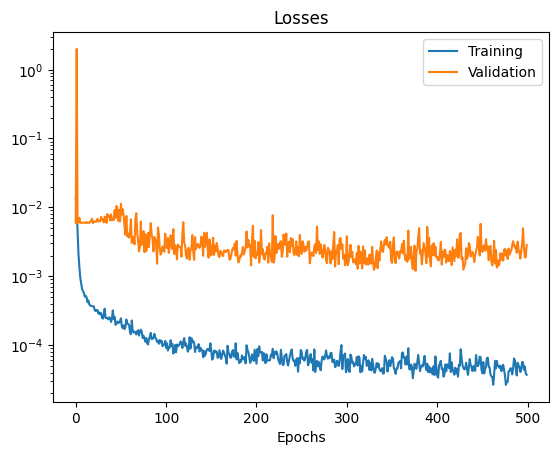

In [19]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Model Predictions

## 1) Test Dataset 1

### 1.1) Making autoregressive predictions

In [20]:
file_id = 10
inputs = normalized_autoregressive_test_dataset_1[file_id]['inputs'] # torch.Size([4, 64, 64])
targets = normalized_autoregressive_test_dataset_1[file_id]['targets'] # torch.Size([12, 64, 64])

# Set the model to evaluation mode to make predictions faster
model.eval()

# Add batch dimension and send to the same device as the model
input_tensor = inputs.unsqueeze(0).float().to(device)

predictions = []
for real_WD in targets[1:]:
    with torch.no_grad():
        # Make a prediction
        
        pred_WD = model(input_tensor) # output = torch.Size([1, 1, 64, 64])
        
        pred_WD_denormalized = scaler_y.inverse_transform(pred_WD.reshape(-1,1).cpu()).reshape(64,64)
        real_WD_denormalized = scaler_y.inverse_transform(real_WD.reshape(-1,1).cpu()).reshape(64,64)
        
        predictions.append((input_tensor[:, 0, :, :].cpu().numpy(), real_WD_denormalized, pred_WD_denormalized.squeeze()))
        
        # Update the input tensor with the current prediction to make the new prediction in the next iteration
        input_tensor = torch.cat((input_tensor[:, :3, :, :], pred_WD), dim=1)

### 1.2) Plotting predictions for a specific time step

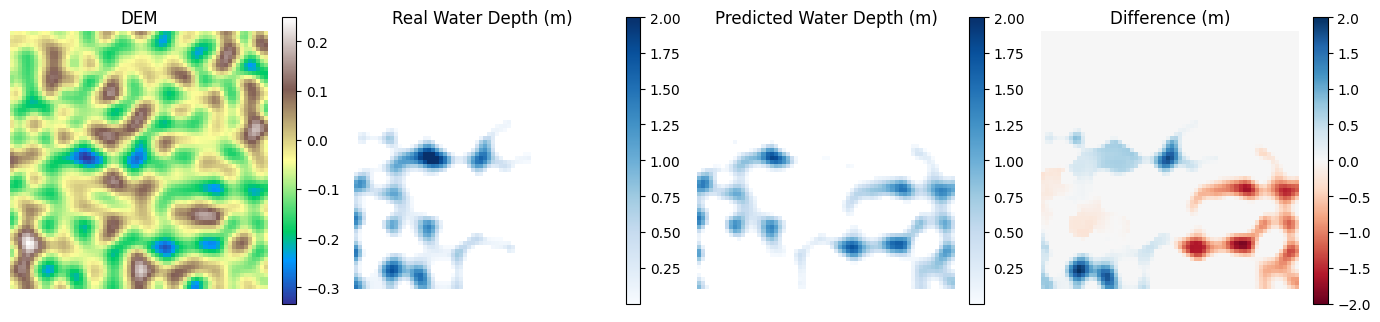

In [21]:
time_step = 10 # Select a time step to do the plot
plot_water_depth_comparison(predictions[time_step][0], predictions[time_step][1], predictions[time_step][2])

### 1.3) Creating a GIF of flood progression based on the predictions

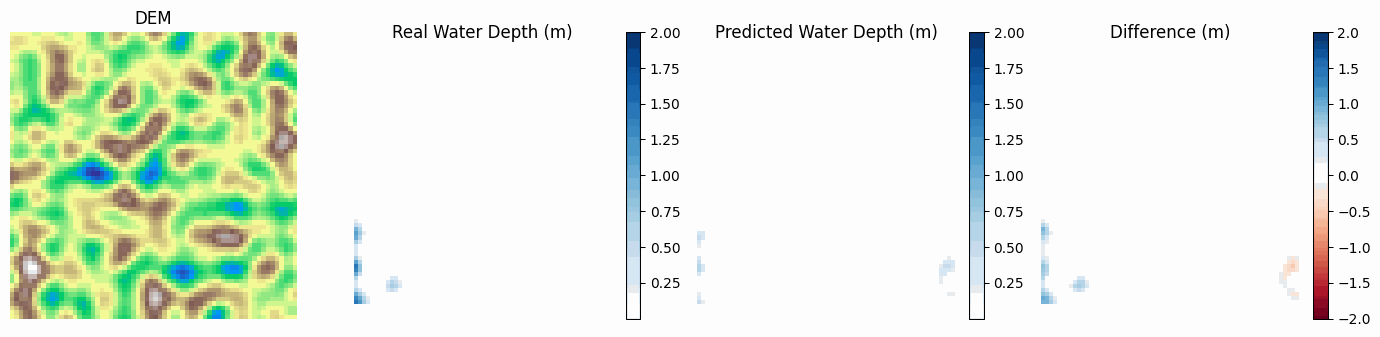

In [22]:
create_gif_from_preds_and_show(predictions, 'water_depth_comparison.gif', duration=1.0)  # Adjust `duration` as needed

## 2) Test Dataset 2

In [26]:
file_id = 2
inputs = normalized_autoregressive_test_dataset_2[file_id]['inputs'] # torch.Size([4, 64, 64])
targets = normalized_autoregressive_test_dataset_2[file_id]['targets'] # torch.Size([12, 64, 64])

# Set the model to evaluation mode to make predictions faster
model.eval()

# Add batch dimension and send to the same device as the model
input_tensor = inputs.unsqueeze(0).float().to(device)

predictions_2 = []
for real_WD in targets[1:]:
    with torch.no_grad():
        # Make a prediction
        
        pred_WD = model(input_tensor) # output = torch.Size([1, 1, 64, 64])
        
        pred_WD_denormalized = scaler_y.inverse_transform(pred_WD.reshape(-1,1).cpu()).reshape(64,64)
        real_WD_denormalized = scaler_y.inverse_transform(real_WD.reshape(-1,1).cpu()).reshape(64,64)
        
        predictions_2.append((input_tensor[:, 0, :, :].cpu().numpy(), real_WD_denormalized, pred_WD_denormalized.squeeze()))
        
        # Update the input tensor with the current prediction to make the new prediction in the next iteration
        input_tensor = torch.cat((input_tensor[:, :3, :, :], pred_WD), dim=1)

### 2.2) Plotting predictions for a specific time step

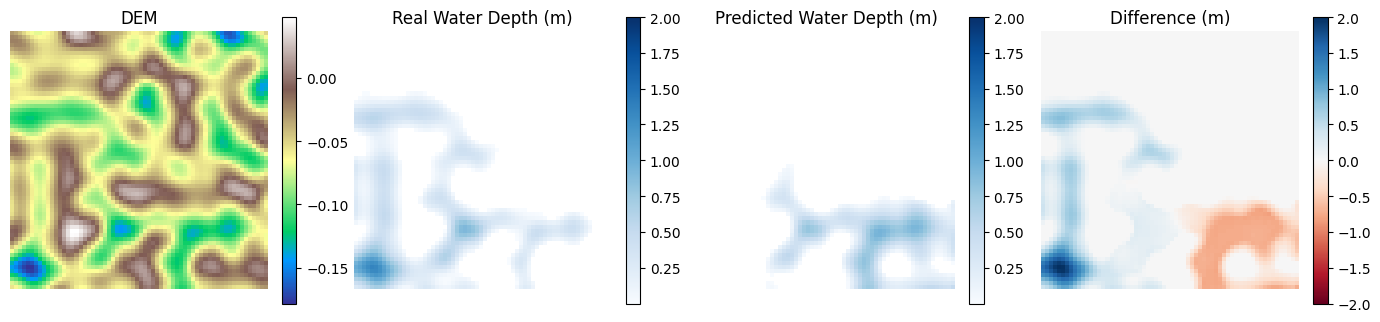

In [27]:
time_step = 10 # Select a time step to do the plot
plot_water_depth_comparison(predictions_2[time_step][0], predictions_2[time_step][1], predictions_2[time_step][2])

### 2.3) Creating a GIF of flood progression based on the predictions

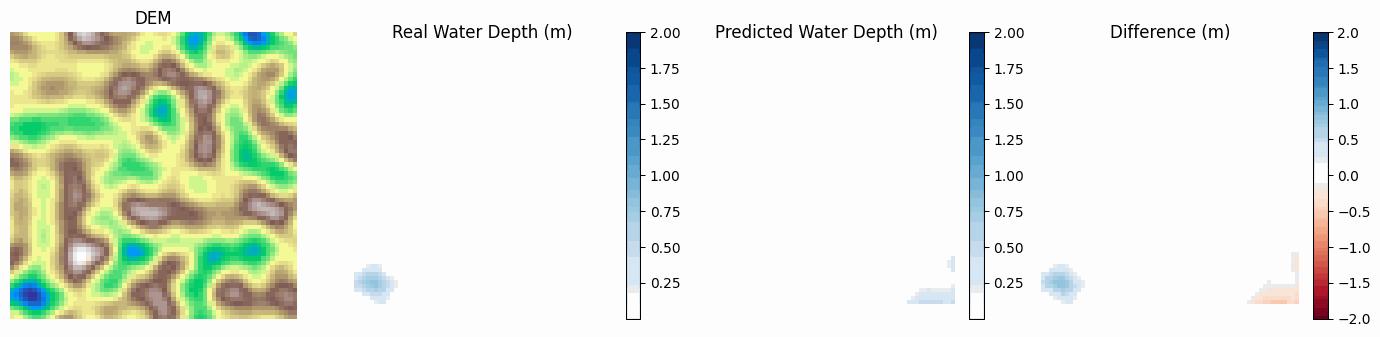

In [28]:
create_gif_from_preds_and_show(predictions_2, 'water_depth_comparison.gif', duration=1.0)  # Adjust `duration` as needed

<div align="center">

# CONCLUSION

</div>

The effects of data augmentation are evident in the model's inference, with predictions starting in different areas of the domain. However, despite the augmentation, the model's reliability in identify the actual dike breach location remains unsatisfactory. To improve its performance, further investigation is required to identify potential reasons or bugs in the code.